# Scraping LADOT Volume Data from PDFs, Part 3

##### Where I Left Off
In the first python notebook (Part 1), I described the problem and general approach I was taking to solve it. I downloaded all the manual count PDF documents and setup the file tables for later.

In the second python notebook (Part 2), I described the process by which I was able to extract volume data from PDFs. I also described the general structure of each of the data tables. At this point, the resulting data has been converted to .csv files, formatted for data analysis.

## Exploring the data
Now that I have the data stored in properly formatted tables, we can get a preview of what we have. We can start by loading the (now) properly formatted tables.

In [16]:
### Setup
%matplotlib inline
import matplotlib
import csv
import glob
from datetime import datetime, date, time
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
import os
import geopandas as gp

# Import file table

# Import output data tables
manualcount_df = pd.read_csv('data/TrafficCountData/Results/manualcount.csv')
pedestrian_df = pd.read_csv('data/TrafficCountData/Results/pedestrian.csv')
peakvol_df = pd.read_csv('data/TrafficCountData/Results/peakvol.csv')
specveh_df = pd.read_csv('data/TrafficCountData/Results/SpecialVehicle.csv')
info_df = pd.read_csv('data/TrafficCountData/Results/info.csv')

info_df.head()

,Unnamed: 0,count_id,date,dayofweek,district,hours,school_day,street_ew,street_ns,weather
0,0,68,2011-04-25,MONDAY,YES,7-10AM 2-5PM,YES,65th PL,VAN NESS AV,SUNNY
1,1,70,2011-09-08,THURSDAY,YES,7-10AM 2-5PM,YES,FLORENCE AV.,KANSAS AV.,SUNNY
2,2,89,2007-07-23,MONDAY,YES,7-10AM 3-6PM,YES,FLORENCE AV,WEST ST,SUNNY
3,3,112,2010-03-08,MONDAY,YES,7-10AM 2-5PM,YES,78TH ST,SAN PEDRO ST,SUNNY
4,4,142,2010-04-23,FRIDAY,YES,7-10AM 3-6PM,YES,92ND ST,GRAHAM AV,SUNNY


##### What dates do we have available?

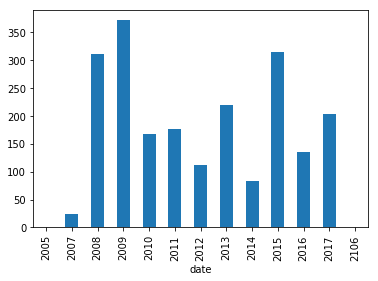

In [17]:
# Convert to datetime column and plot count by year
info_df["date"] = info_df["date"].astype("datetime64[ns]")
count_date_groups = info_df['date'].groupby([info_df["date"].dt.year]).count()
count_date_groups.plot(kind="bar")

##### Import the BOE Centerline File

In [6]:
import geopandas as gp
import folium

# Import BOE Intersection spatial data, drop unnecessary columns
boe_int = gp.GeoDataFrame.from_file('data/intersections/Intersections.shp')
boe_int = boe_int.drop(['OBJECTID', 'X', 'Y', 'TYPE', 'CRTN_DT', 'LST_MODF_D', 'USER_ID', 'ZIP_CODE'], axis=1)

boe_int.head()

,ASSETID,CL_NODE_ID,LAT,LON,FROM_ST,TO_ST,TOOLTIP,NLA_URL,geometry
0,96967,13589,34.045852,-118.556794,PASEO MIRAMAR,ESPERA AVE,PASEO MIRAMAR at ESPERA AVE,navigatela/reports/intersection_report.cfm?pk=...,POINT (-118.5568057440078 34.04585714775025)
1,96968,13634,34.052279,-118.513895,VILLA WOODS PL,D/E,VILLA WOODS PL at D/E,navigatela/reports/intersection_report.cfm?pk=...,POINT (-118.5139074746574 34.0522839749969)
2,96969,13660,34.050261,-118.537311,ALCIMA AVE,LAS LOMAS AVE,ALCIMA AVE at LAS LOMAS AVE,navigatela/reports/intersection_report.cfm?pk=...,POINT (-118.5373235321818 34.0502655043602)
3,96970,15007,34.108027,-118.267080,WEST SILVER LAKE DR,ROWENA AVE,WEST SILVER LAKE DR at ROWENA AVE,navigatela/reports/intersection_report.cfm?pk=...,POINT (-118.267092077783 34.10803167807186)
4,96971,15024,34.106243,-118.270866,ANGUS ST,PANORAMA TER,ANGUS ST at PANORAMA TER,navigatela/reports/intersection_report.cfm?pk=...,POINT (-118.2708777616466 34.10624778706446)


In [2]:
# Join BOE table to info table
file_tbl_boe = file_table.merge(boe_int,
                                how='left',
                                left_on = 'cl_node_id',
                                right_on = 'CL_NODE_ID')
Print('There are ' + str(file_tbl_boe['CL_NODE_ID'].nunique()) + ' unique locations with counts.')

NameError: name 'file_table' is not defined

##### Test out Mapping the Points
For this first map, I'm just mapping the locations of the counts, using the MarkerCluster Folium Plugin to aggregate the counts on the map view. Even with this MarkerCluster, I was only able to get 1,500 data points mapped at one time, so what is shown on the map is only a subset of the available data points.

In [100]:
from folium.plugins import MarkerCluster

# Create new LA Basemap specifying map center, zoom level, and using Stamen Toner Tiles
count_map = folium.Map([34.109279, -118.266087],
                       tiles='Stamen Toner',
                       zoom_start=11)

# Create marker cluster object
marker_cluster = MarkerCluster().add_to(count_map)

# Remove points with NaN Coodinate values
file_tbl_boe = file_tbl_boe[pd.notnull(file_tbl_boe['LAT'])]
file_tbl_boe = file_tbl_boe[pd.notnull(file_tbl_boe['LON'])]

# Map out locations and document labels
locationlist = file_tbl_boe[['LAT','LON']].values.tolist()
labels = file_tbl_boe["DocName"].values.tolist()


#for point in range(len(locationlist)):
for point in range(1500):
    popup = folium.Popup(labels[point], parse_html=True)
    folium.Marker(locationlist[point], popup = popup).add_to(marker_cluster)

# Show the map
count_map

##### Map the Ped Volumes
Beyond mapping the locations, we can map the actual values of the counts. Since I want the area of the circle to represent the count, I will set the radius to be the square root of the count.

In [ ]:
### Prepare the ped volume data for mapping
import numpy as np

# Import tables related to volume
info_df = pd.read_csv('data/TrafficCountData/Results/info.csv', index_col=0)
pedestrian_df = pd.read_csv('data/TrafficCountData/Results/pedestrian.csv', index_col=0)

# Sum volumes by count_id
by_count_id = pedestrian_df.groupby('count_id')
ped_count_sum = by_count_id['volume'].aggregate(np.sum).to_frame().reset_index()

# Merge with info table
ped_sum_df = info_df.merge(ped_count_sum,
                           how = 'left',
                           left_on = 'count_id',
                           right_on = 'count_id')

ped_sum_df.head()

# Left join the traffic data table to the count info table
ped_sum_boe_df = ped_sum_df.merge(file_tbl_boe,
                                  how='left',
                                  left_on = 'count_id',
                                  right_on = 'ID')

# Remove points with NaN Coodinate values
ped_sum_boe_df = ped_sum_boe_df[pd.notnull(ped_sum_boe_df['LAT'])]
ped_sum_boe_df = ped_sum_boe_df[pd.notnull(ped_sum_boe_df['LON'])]

# Take a look at the length and head of the new table
print(len(ped_sum_boe_df))
ped_sum_boe_df['CL_NODE_ID'].nunique()

In [99]:
### Map the ped data
import math

# Create new LA Basemap specifying map center, zoom level, and using Stamen Toner Tiles
pedvol_map = folium.Map([34.109279, -118.266087],
                        tiles='Stamen Toner',
                        zoom_start=11)



# Map out locations and document labels
locationlist = ped_sum_boe_df[['LAT','LON']].values.tolist()
labels = ped_sum_boe_df["DocName"].values.tolist()
size = ped_sum_boe_df['volume'].values.tolist()

#for point in range(len(locationlist)):
for point in range(1300):
    popup = folium.Popup(labels[point], parse_html=True)
    folium.CircleMarker(locationlist[point], radius=(math.sqrt(size[point])/3),
                        popup = popup, line_color='#3186cc',
                        fill_color='#3186cc', fill=True).add_to(pedvol_map)

# Show the map
pedvol_map

In [102]:
specveh_df = pd.read_csv('data/TrafficCountData/Results/SpecialVehicle.csv', index_col=0)
specveh_df.head()

,approach,type,volume
0,SB,dual,37
1,SB,bike,3
2,SB,bus,12
3,NB,dual,39
4,NB,bike,7


In [ ]:
# Left join the traffic data table to the count info table
ped_sum_boe_df = ped_sum_df.merge(file_tbl_boe,
                                  how='left',
                                  left_on = 'count_id',
                                  right_on = 'ID')

# Take a look at the length and head of the new table
print(len(ped_sum_boe_df))
ped_sum_boe_df